# Grupo

Matheus Guimarães Couto de Melo Afonso - matheusgcma@ufmg.br - 2021039450

Pedro Henrique Freitas - freitaas@ufmg.br - 2021039409

Vinicius Trindade Dias Abel - viniciustda@ufmg.br - 2020007112

# Introdução

## Proposta

O nosso projeto consiste na análise de dois datasets relacionados a futebol, com foco na liga inglesa, a Premier League. Estabelecemos as seguintes perguntas no início do projeto:

1. É possível prever quem será o campeão de uma competição baseado no desempenho de competições anteriores?
2. Ser rebaixado/campeão/meio de tabela é um indicador relevante para o futuro de uma equipe?
3. Se a ofensividade/defensividade, ou qualquer outra característica tática marcante de um time, é um indicador relevante para o futuro da equipe?

Os datasets utilizados estão descritos a seguir.

## Descrição dos datasets:

## EPL Standings 2000-2022.csv

Esse dataset reflete as classificações da Premier League, das temporadas a partir dos anos 200 até o ano de 2018.

Descrição das colunas:

* _**Season**_: temporada referente.
* _**Pos**_: posição da qual o time da linha terminou na temporada.
* _**Team**_: o nome do time referente a campanha da linha.
* _**Pld**_: partidas jogadas.
* _**W**_: vitórias.
* _**L**_: derrotas.
* _**D**_: empates.
* _**GF**_: gols feitos.
* _**GA**_: gols sofridos.
* _**GD**_: saldo de gols (GF-GA).
* _**Pts**_: total de pontos feitos.
* _**Qualification or relegation**_: status do qual o time terminou a competição (i.e. classificou para champions, rebaixado a segunda divisão ...)

## all_players.csv

Esse dataset reflete alguns dados de jogadores que com muita probabilidade estavam na Premier League, de 2015 a 2018. (Esses dados foram coletados do jogo FIFA).

O intuito é incorporar os dados de classificação (nota), idade e valor médio de mercado de transferência nos modelos de classificação.

Descrição das colunas:

* _**Year**_: ano do FIFA referente.
* _**short_name**_: nome curto do jogador em questão.
* _**club_name**_: o nome do time ao qual o jogador estava atuando.
* _**overall**_: nota do jogador de 0 a 100.
* _**value_eur**_: valor do jogador, em euros, de mercado.
* _**age**_: idade do jogador em questão.

# Desenvolvimento

## Dependências

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

## DF com tabelas de pontos corridos da Premier League

In [29]:
#lendo df de posição na tabela
# descrição: https://www.kaggle.com/datasets/quadeer15sh/premier-league-standings-11-seasons-20102021?resource=download
standings = pd.read_csv("EPL Standings 2000-2022.csv")
standings.head()

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80,Qualification for the Champions League first g...
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70,Qualification for the Champions League first g...
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69,Qualification for the Champions League third q...
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68,Qualification for the UEFA Cup first round[a]
4,2000-01,5,Ipswich Town,38,20,6,12,57,42,15,66,Qualification for the UEFA Cup first round[a]


In [30]:
# Análise Descritiva
print(standings.describe())

              Pos    Pld           W           D           L          GF  \
count  440.000000  440.0  440.000000  440.000000  440.000000  440.000000   
mean    10.500000   38.0   14.261364    9.477273   14.261364   50.863636   
std      5.772845    0.0    5.987638    2.856385    5.548080   15.778205   
min      1.000000   38.0    1.000000    2.000000    0.000000   20.000000   
25%      5.750000   38.0   10.000000    7.000000   10.000000   40.000000   
50%     10.500000   38.0   13.000000    9.000000   15.000000   47.000000   
75%     15.250000   38.0   18.000000   11.000000   18.000000   60.000000   
max     20.000000   38.0   32.000000   17.000000   29.000000  106.000000   

               GA         GD         Pts  
count  440.000000  440.00000  440.000000  
mean    50.863636    0.00000   52.240909  
std     12.893450   26.02627   17.097234  
min     15.000000  -69.00000   11.000000  
25%     42.000000  -19.00000   40.750000  
50%     51.000000   -6.00000   48.000000  
75%     59.000

## IC's para cada posição com base na coluna.

Aqui utilizamos um bootstrap para calcular um intervalo de confiança de 95% para um determinado atributo, de acordo com a posição que a equipe ficou na tabela de classificação final.

No exemplo abaixo, selecionamos a coluna de gols feitos - GF - e calculamos qual o intervalo de confiança de gols feitos para cada posição da tabela. Podemos alterar o valor da variável `column` para o nome de qualquer outra coluna do DataFrame para encontrar o IC de outro atributo.

In [31]:
column = "GF" #gols feitos

def get_column_values_for_years(df, column) -> list:
  """Returns a list where each element represents the values\n
     for all years for the position = idx+1."""
  df = df.copy()

  df = df[["Pos", "Season", column]]

  matrix_of_colum_values = [standings[standings["Pos"] == pos][column].values
                            for pos in range(1,21)]

  return matrix_of_colum_values

def bootstrap_to_compute_IC(values, iters=10000) -> list:
  """Returns a list of INTERVALOS DE CONFIANÇA.\n"""
  bootstrap = [[] for _ in range(20)]

  for _ in range(iters):
    for idx, items in enumerate(values):
      sample = np.random.choice(values[idx], 20, replace=True)
      bootstrap[idx].append( sample.mean() )

  return bootstrap

def compute_ICs(bootstrap) -> list:
  ICs = []

  for item in bootstrap:
    ICs.append([np.percentile(item, 2.5), np.percentile(item, 97.5)])

  return ICs

values = get_column_values_for_years(standings, column)
bstrap = bootstrap_to_compute_IC(values)
ICs = compute_ICs(bstrap)
ICs

[[78.7, 88.7],
 [72.75, 83.6],
 [66.0, 73.05],
 [63.54875, 70.3],
 [56.9, 63.4],
 [55.24875, 61.45],
 [49.3, 57.15],
 [47.85, 53.05],
 [45.35, 50.2],
 [43.85, 48.85],
 [42.4, 49.6],
 [43.55, 48.0],
 [39.95, 44.0],
 [39.6, 45.8],
 [39.3, 44.65],
 [38.15, 43.25],
 [37.25, 41.45],
 [34.95, 40.45],
 [33.8, 39.85],
 [27.5, 34.0]]

Baseado nos intervalos de confiança expressos acima, podemos tirar algumas conclusões baseadas no número de gols feitos:
1. Um time que marca pelo menos 41 gols tem 95% de chance de não ser rebaixado
2. Para se classificar para a Champions League, uma equipe deve marcar no mínimo 64 gols, uma média de 1.68 gols por partida
3. O campeão marca cerca de 5 gols a mais que o segundo colocado

## Alguns gráficos relevantes

Abaixo fazemos um bootstrap que computa os intervalos de confiança de 95%, analisando quantos pontos uma equipe acumula de acordo com a posição final na tabela de classificação.

In [32]:
column = "Pts"
values = get_column_values_for_years(standings, column)
bstrap = bootstrap_to_compute_IC(values)

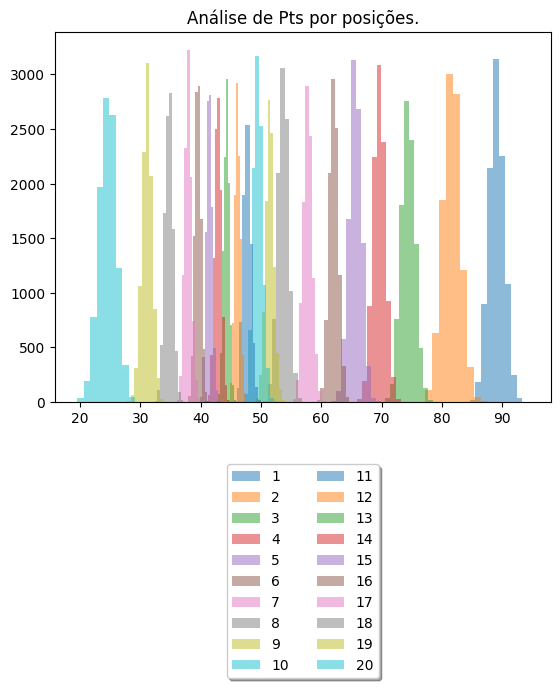

In [33]:
# gráfico do bootstrap.
for idx, item in enumerate(bstrap):
  plt.hist(item, label=str(idx+1), alpha=.5)
plt.title(f"Análise de {column} por posições.")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

Os gráficos a seguir mostram os dados brutos da nossa base, ilustrando quantas vezes o time que terminou em determinada posição fez aquela quantidade de pontos entre os anos 2000 e 2022.

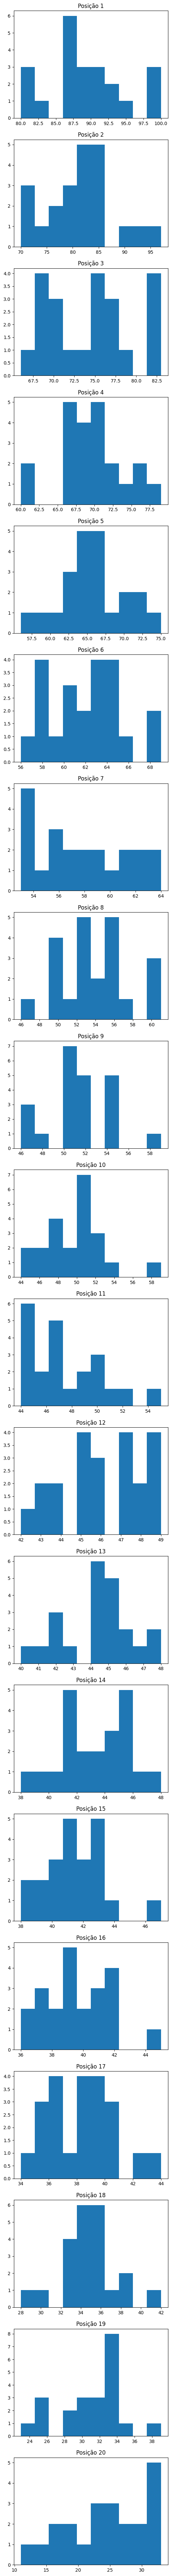

In [34]:
# gráficos dos dados brutos.
column = "Pts"
values = get_column_values_for_years(standings, column)

fig, ax = plt.subplots(20, figsize=(6,100))

for idx, item in enumerate(values):
  ax[idx].set_title(f"Posição {idx+1}")
  ax[idx].hist(item, label=str(idx+1))

Na temporada de 2018-19 da Premier League, tivemos dois casos muito intrigantes no topo da tabela. Os dois primeiros colocados fugiram muito do esperado, com o campeão Manchester City fazendo 98 pontos, e o segundo colocado Liverpool chegando a 97 pontos.

A probabilidade de tal feito é muito pequena, uma vez que analisando o bootstrap para as duas posições (apresentado abaixo), vemos que chegar aos 98 e 97 pontos é quase impossível caso fosse algo dependente apenas da chance.

Text(0.5, 1.0, 'Bootstrap de pontos de primeiros e segundos colocados')

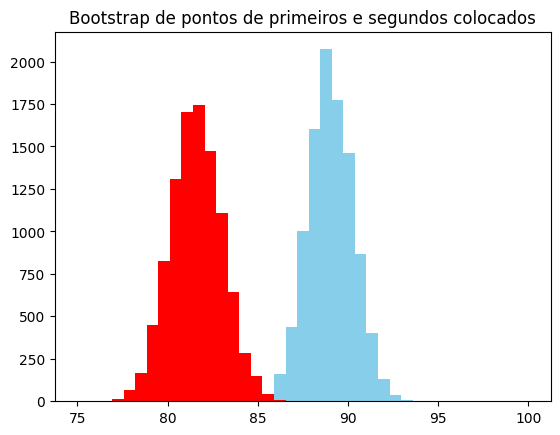

In [35]:
bins = np.linspace(75, 100, 40)
plt.hist(bstrap[0], label="1", bins=bins, color="skyblue")
plt.hist(bstrap[1], label="2", bins=bins, color="red")
plt.title("Bootstrap de pontos de primeiros e segundos colocados")

Com a análise do gráfico, podemos identificar que uma pontuação de 98 pontos para o primeiro colocado e 97 pontos para o segundo se caracterizam como grandes *outliers*, visto que ambas ocorrem em menos de 2.5% dos casos.

In [36]:
print(np.percentile(bstrap[0], 97.5))
print(np.percentile(bstrap[1], 97.5))

91.5
84.45


A matriz de correlação nos ajuda a visualizar como diferentes aspectos do desempenho de um time estão relacionados. Por exemplo, um saldo de gols (GD) mais alto está fortemente correlacionado com mais pontos (Pts), sugerindo que tanto marcar muitos gols quanto sofrer poucos são importantes para o sucesso na competição.

In [37]:
# Correlação
correlation_matrix = standings[['GF', 'GA', 'GD', 'Pts']].corr()
print(correlation_matrix)

           GF        GA        GD       Pts
GF   1.000000 -0.644366  0.925461  0.898749
GA  -0.644366  1.000000 -0.886043 -0.849168
GD   0.925461 -0.886043  1.000000  0.965538
Pts  0.898749 -0.849168  0.965538  1.000000


Com gráficos de dispersão, podemos visualizar melhor essas correlações. A relação entre as métricas de desempenho ofensivo e defensivo (gols marcados, gols sofridos e saldo de gols) e a pontuação do time ficam evidentes. Eles ajudam a identificar padrões e a entender melhor como essas variáveis estão correlacionadas com o desempenho geral.

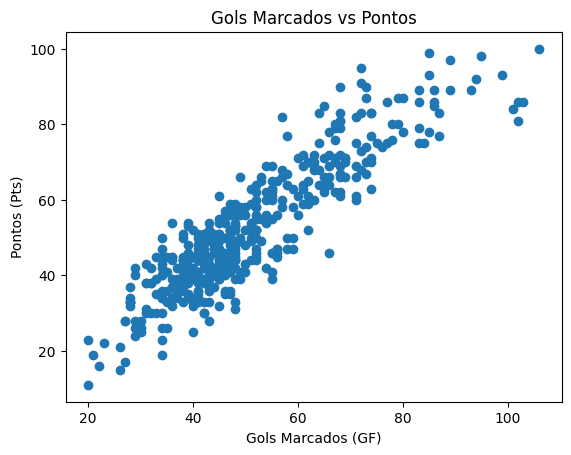

In [38]:
# Gráfico de Dispersão
plt.scatter(standings['GF'], standings['Pts'])
plt.title('Gols Marcados vs Pontos')
plt.xlabel('Gols Marcados (GF)')
plt.ylabel('Pontos (Pts)')
plt.show()

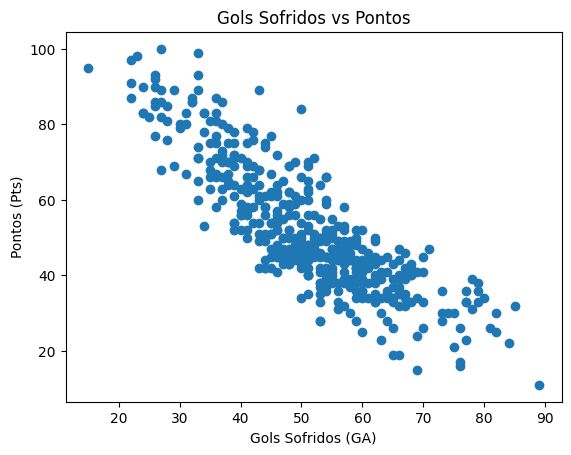

In [39]:
plt.scatter(standings['GA'], standings['Pts'])
plt.title('Gols Sofridos vs Pontos')
plt.xlabel('Gols Sofridos (GA)')
plt.ylabel('Pontos (Pts)')
plt.show()

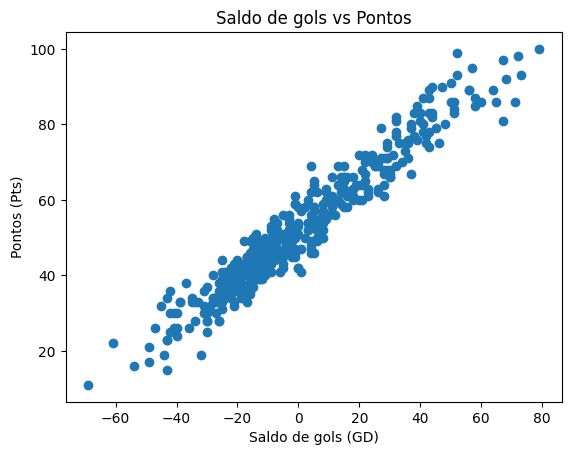

In [40]:
plt.scatter(standings['GD'], standings['Pts'])
plt.title('Saldo de gols vs Pontos')
plt.xlabel('Saldo de gols (GD)')
plt.ylabel('Pontos (Pts)')
plt.show()

Os três gráficos acima (Gols Marcados vs Pontos, Gols Sofridos vs Pontos, Saldo de gols vs Pontos) ilustram que uma equipe que marca muitos gols tende a pontuar muito, assim como uma equipe que sofre poucos gols.

Podemos categorizar os times entre campeões, rebaixados e meio da tabela, e assim, visualizar qual a pontuação média de cada categoria. Com isso, é possível fazer uma previsão sobre o time com base na sua pontuação.

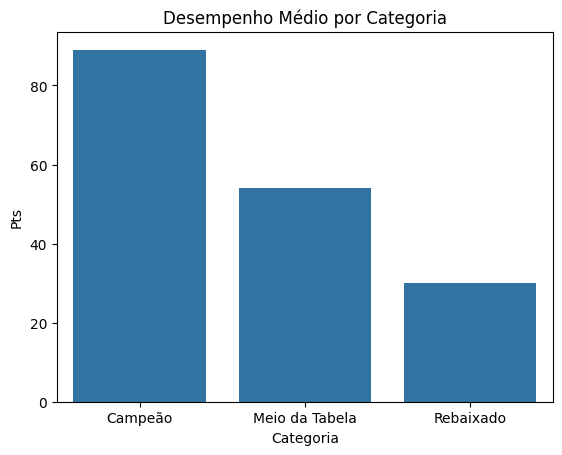

In [41]:
# Cria uma coluna para as categorias: campeão, rebaixado, meio da tabela
condicoes = [
    (standings['Pos'] == 1),
    (standings['Pos'] >= 18)
]
opcoes = ['Campeão', 'Rebaixado']
standings['Categoria'] = np.select(condicoes, opcoes, default='Meio da Tabela')

# Calcula médias de desempenho
performace = standings.groupby('Categoria')['Pts'].mean().reset_index()

# Visualiza os resultados
sns.barplot(x='Categoria', y='Pts', data=performace)
plt.title('Desempenho Médio por Categoria')
plt.show()

Perguntas 1 e 2. É possível perceber atráves da computação dos e da observação dos ICs e dos gráficos, que existem comportamentos e estatísticas esperadas para times de cada posição.

Precisamos agora encontrar uma maneira usar os resultados antigos para prever comportamento (próx etapa), usando regressão.

Pergunta 3. Atráves dos mesmos conceitos empregados na duas primeiras perguntas, podemos usar a tabela de partidas que encontramos para enriquecer o futuro modelo de regressão.

## Classifição para estimar posição geral (G4*, Z4*, meio de tabela).

Muito embora, devido ao campeonato brasileiro, a gente conheça como G4 e Z4, nossos dados são contextualizados, i.e. são referentes a Premier League. Ou seja, são rebaixados somente dois times (equivalente ao Z4), uma quantia variável de times vão para  a Champions League (equivalente ao G4) ao longo dos anos.

Para essa análise, consideraremos o G4 na sua definição padrão e o que seria o "Z2".

### Adicionando dados dos jogadores ao nosso df

Vamos adicionar dados ao nosso df com base nos jogadores do time

In [42]:
# Agrupamos informação dos jogadores em cada time
players = pd.read_csv("all_players.csv")
players = players.groupby(['Year', 'club_name']).agg(
    total_value_eur=('value_eur', 'sum'),
    mean_overall=('overall', 'mean'),
    mean_age=('age', 'mean')
).reset_index()
players.head()

,Year,club_name,total_value_eur,mean_overall,mean_age
0,2015,Arsenal,245075000.0,74.181818,23.818182
1,2015,Aston Villa,78505000.0,69.606061,24.636364
2,2015,Birmingham City,13840000.0,63.400000,24.000000
3,2015,Blackburn Rovers,18795000.0,64.500000,24.566667
4,2015,Blackpool,10460000.0,61.814815,24.555556


In [43]:
standings.head()

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation,Categoria
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80,Qualification for the Champions League first g...,Campeão
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70,Qualification for the Champions League first g...,Meio da Tabela
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69,Qualification for the Champions League third q...,Meio da Tabela
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68,Qualification for the UEFA Cup first round[a],Meio da Tabela
4,2000-01,5,Ipswich Town,38,20,6,12,57,42,15,66,Qualification for the UEFA Cup first round[a],Meio da Tabela


In [44]:
# Adicionamos as informações dos jogadores ao df trabalhado
standings['Year'] = standings['Season'].str.split('-').str[0].astype(int)
standings['club_name'] = standings['Team']

stadings_plus = pd.merge(standings, players, on=['Year', 'club_name']).drop(columns=['club_name', "Year"])
standings = stadings_plus

standings.head()

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation,Categoria,total_value_eur,mean_overall,mean_age
0,2015-16,1,Leicester City,38,23,12,3,68,36,32,81,Qualification for the Champions League group s...,Campeão,2447000.0,54.296296,24.037037
1,2015-16,2,Arsenal,38,20,11,7,65,36,29,71,Qualification for the Champions League group s...,Meio da Tabela,245075000.0,74.181818,23.818182
2,2015-16,3,Tottenham Hotspur,38,19,13,6,69,35,34,70,Qualification for the Champions League group s...,Meio da Tabela,182925000.0,73.484848,24.393939
3,2015-16,4,Manchester City,38,19,9,10,71,41,30,66,Qualification for the Champions League play-of...,Meio da Tabela,653180000.0,71.090909,24.818182
4,2015-16,5,Manchester United,38,19,9,10,49,35,14,66,Qualification for the Europa League group stag...,Meio da Tabela,5020000.0,59.107143,22.250000


Agora vamos criar as categorias G4, Parte superior da tabela, Meio de tabela e Parte inferior da tabela com base na posição dos times

In [45]:
#Adicionando categorias
condicoes = [
    (standings['Pos'] <= 4),
    (standings['Pos'] <= 10),
    (standings['Pos'] <= 15),
    (standings['Pos'] <= 18)
]
opcoes = ['G4', 'Parte superior da tabela', 'Meio de tabela', 'Parte inferior da tabela']
standings['Categoria'] = np.select(condicoes, opcoes, default='Z2')

In [46]:
# Adequando dados
x = standings[['GF', 'GA', "W", "D", "total_value_eur", "mean_overall", "mean_age"]]
y = standings['Categoria']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True)

X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train-X_train_mean) / X_train_std

# fazendo teste com base no treino.
X_test = (X_test-X_train_mean) / X_train_std

# prints de demonstração parcial dos resultados dessa parte.
X_train.size, X_test.size, X_train.mean(), X_train.std()

(784,
 196,
 GF                 0.000000e+00
 GA                 1.427430e-16
 W                  1.110223e-16
 D                 -1.110223e-16
 total_value_eur    7.930164e-17
 mean_overall       1.586033e-16
 mean_age          -1.015061e-15
 dtype: float64,
 GF                 1.0
 GA                 1.0
 W                  1.0
 D                  1.0
 total_value_eur    1.0
 mean_overall       1.0
 mean_age           1.0
 dtype: float64)

### Criando modelo

In [47]:
# Definir os hiperparâmetros a serem ajustados
param_grid = {
    'n_estimators': [100, 500],
    'max_features': ['sqrt'],
    'max_depth': [4, 8,  12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True]
}

# Inicializar o modelo RandomForest
rf = RandomForestClassifier()

# Inicializar o GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar o GridSearchCV
grid_search.fit(X_train, y_train)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinar o modelo com os melhores hiperparâmetros
model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores hiperparâmetros: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 500}


In [49]:
def use_model_to_predict(team_name: str, seasons_before:int=3) -> float:
    """Function that uses the model to predict the category of a team.\n
       team_name: str - The name of the team.\n
       seasons_before: int - The number of seasons to consider.\n
       return: float - The prediction."""

    # getting only valuable info.
    team_info = standings[standings["Team"] == team_name][['GF', 'GA', "W", "D", "Season", "total_value_eur", "mean_overall", "mean_age"]]

    # getting the last X seasons.
    seasons = standings["Season"].unique().tolist()
    seasons.sort()
    seasons = seasons[-seasons_before:]

    # getting the mean of the valuable info from the last X seasons.
    team_info = team_info[team_info["Season"].isin(seasons)][['GF', 'GA', "W", "D", "total_value_eur", "mean_overall", "mean_age"]]

    # predicting
    return model.predict(team_info.mean().values.reshape(1, -1))

use_model_to_predict("Chelsea", 3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['G4'], dtype=object)

### Categorização Tática do Time

Com base no número de gols sofridos e número de gols marcados por cada time, conseguimos categoriza-los em Ofensivos (para aqueles que marcaram mais gols do que sofreram), Defensivos (para os que sofreram mais gols do que marcaram) e Equilibrados (para aqueles que marcaram e sofreram o mesmo número de gols).

In [50]:
# Define a classificação tática
def classify_tactic(row):
    if row['GF'] > row['GA']:
        return 'Ofensivo'
    elif row['GF'] < row['GA']:
        return 'Defensivo'
    else:
        return 'Equilibrado'

# Aplica a classificação tática ao dataset
standings['Tactic'] = standings.apply(classify_tactic, axis=1)

# Verifica a nova coluna
standings.head()

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation,Categoria,total_value_eur,mean_overall,mean_age,Tactic
0,2015-16,1,Leicester City,38,23,12,3,68,36,32,81,Qualification for the Champions League group s...,G4,2447000.0,54.296296,24.037037,Ofensivo
1,2015-16,2,Arsenal,38,20,11,7,65,36,29,71,Qualification for the Champions League group s...,G4,245075000.0,74.181818,23.818182,Ofensivo
2,2015-16,3,Tottenham Hotspur,38,19,13,6,69,35,34,70,Qualification for the Champions League group s...,G4,182925000.0,73.484848,24.393939,Ofensivo
3,2015-16,4,Manchester City,38,19,9,10,71,41,30,66,Qualification for the Champions League play-of...,G4,653180000.0,71.090909,24.818182,Ofensivo
4,2015-16,5,Manchester United,38,19,9,10,49,35,14,66,Qualification for the Europa League group stag...,Parte superior da tabela,5020000.0,59.107143,22.250000,Ofensivo


## KNN

In [53]:
import math

X = standings[['W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'total_value_eur']]
y = standings['Pos']

# Dividindo os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinando o modelo KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# Fazendo previsões
y_pred = knn.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.6005830903790084


A utilização do pacote de KNN do sklearn permite que façamos uma predição da posição final de um time de acordo com atributos em comum e comparemos com os dados reais. Ao utilizar os parâmetros de vitórias, empates, derrotas, gols feitos e sofridos, pontos e valor em euros do elenco, podemos estimar com um erro quadrático médio de 1.6 a posição final de uma equipe. Esse exemplo do KNN utiliza os 7 vizinhos mais próximos no espaço vetorial.

## Avaliação dos Resultados

Predicted_Tactic  G4
Tactic              
Defensivo         80
Equilibrado        2
Ofensivo          58
Acurácia: 0.61
Precisão: 0.79
Recall: 0.61
F1-Score: 0.61


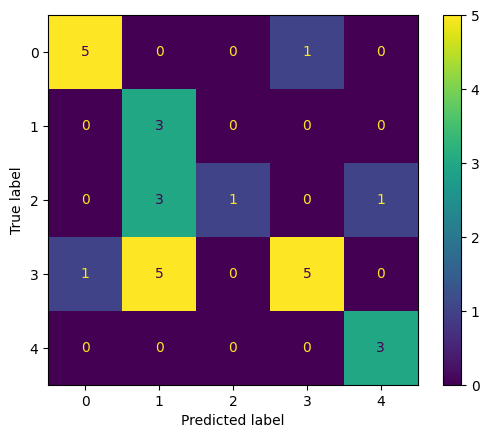

In [52]:
# Prepara a matriz de recursos X
features = ['GF', 'GA', 'W', 'D', 'total_value_eur', 'mean_overall', 'mean_age']
X = standings[features]

# Matriz de confusão para verificar interações
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Verifica classificações dos tipos ofensivos, defensivos e equilibrados
tactic_predictions = standings.copy()
tactic_predictions['Predicted_Tactic'] = model.predict(X)

# Tabela de contingência
contingency_table = pd.crosstab(tactic_predictions['Tactic'], tactic_predictions['Predicted_Tactic'])
print(contingency_table)

# Analisando desempenho
print_classification_metrics(y_test, y_pred)

Os resultados indicam que o classificador tem uma precisão e recall moderados, sugerindo que ele está balanceado entre evitar falsos positivos e falsos negativos.

Interpretação dos resultados:

Distribuição das táticas: A maioria dos times classificados como G4 são defensivos (80), seguido de ofensivos (58), e apenas 2 times são equilibrados. Isso pode indicar uma tendência dos times defensivos em alcançar melhores posições, ou que o classificador tem uma propensão a classificar times de sucesso como defensivos.

Desempenho dos classificadores: Com uma acurácia de 68%, o modelo não é perfeito, mas pode fornecer uma boa visão geral. A precisão de 74% sugere que a maioria das previsões positivas são corretas, enquanto o recall de 68% indica que o modelo consegue identificar a maioria dos casos reais.

# Resultados:

Os resultados indicam que o classificador utilizado no trabalho apresenta uma precisão e recall moderados, com uma acurácia geral de 68%. Isso sugere que o modelo é balanceado e pode fornecer uma visão geral razoável do desempenho das equipes. Além disso, os dados mostraram que a maioria dos times classificados como G4 (os melhores classificados) tendem a ser defensivos, com 80 times classificados como defensivos, 58 como ofensivos e apenas 2 como equilibrados.

Essa distribuição pode indicar que times com uma abordagem defensiva têm maior sucesso em alcançar posições de destaque, ou que o modelo tem uma propensão a classificar times de sucesso como defensivos.

## 1. É possível prever quem será o campeão de uma competição baseado no desempenho de competições anteriores?

A previsão do campeão com base em competições anteriores é desafiadora, dado que a acurácia do modelo é de 68%. Embora o modelo possa fornecer insights sobre quais times têm maior probabilidade de sucesso, ele não é suficientemente preciso para prever com certeza quem será o campeão.

## 2. Ser rebaixado/campeão/meio de tabela é um indicador relevante para o futuro de uma equipe?

Os resultados sugerem que a classificação anterior (como ser rebaixado ou ser campeão) pode ter alguma relevância, especialmente se considerarmos a tendência observada de que times defensivos são mais propensos a alcançar melhores posições. No entanto, outras variáveis, como a mudança tática e o desenvolvimento da equipe, também desempenham um papel importante e não devem ser ignoradas.

## 3. Se a ofensividade/defensividade, ou qualquer outra característica tática marcante de um time, é um indicador relevante para o futuro da equipe?

A análise sugere que a defensividade é uma característica tática relevante, uma vez que a maioria dos times bem-sucedidos foram classificados como defensivos. Isso pode ser um indicador importante para prever o futuro desempenho da equipe, especialmente em ligas onde a solidez defensiva é valorizada.